In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import metrics 

## Prepare the data

In [2]:
churn_df = pd.read_csv("../data/churn_train.csv")

In [3]:
churn_df.shape

(572171, 22)

In [97]:
churn_df.churn_label.mean()

0.6626096044713905

In [4]:
churn_df.head()

,freq_w1,play_time_w1,avg_play_pct_w1,freq_w2,play_time_w2,avg_play_pct_w2,freq_w3,play_time_w3,avg_play_pct_w3,play_recency,...,down_uniq_singer_num_w1,down_freq_w2,down_uniq_song_num_w2,down_uniq_singer_num_w2,down_freq_w3,down_uniq_song_num_w3,down_uniq_singer_num_w3,down_recency,device_is_android,churn_label
0,45.0,9027.0,0.949343,114.0,24372.0,0.900190,109.0,24790.0,0.972819,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999,0,0
1,4.0,184611.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,33,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,33,1,1
2,0.0,0.0,0.000000,2.0,102.0,0.325743,0.0,0.0,0.000000,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999,1,1
3,354.0,13547.0,0.148254,283.0,14781.0,0.202751,333.0,15397.0,0.179196,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999,1,0
4,13.0,780.0,0.239631,0.0,0.0,0.000000,10.0,1665.0,0.616586,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999,1,1


In [5]:
X = churn_df.drop(['churn_label'], axis=1)
y = churn_df.churn_label

In [6]:
print X.shape, y.shape

(572171, 21) (572171,)


In [7]:
RANDOM_SEED = 24
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = RANDOM_SEED
)

## xgboost tuning

In [8]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [9]:
def xgb_fit(alg, x_train, y_train, x_test, y_test,
            useTrainCV=True, cv_folds=5, early_stopping_rounds=10, seed=RANDOM_SEED):
    
    if useTrainCV:
        print 'Use the built-in CV in xgboost to determine the best n_estimators...\n'
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train.values, label=y_train)
        xgtest = xgb.DMatrix(x_test.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds, verbose_eval=True,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds, seed=seed)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    print '\nThe best n_estimetors is {}'.format(cvresult.shape[0])
    print '\nTrain the xgboost model using best n_estimators from CV...\n'
    alg.fit(x_train, y_train, eval_metric='auc') # no need for setting eval_metric...
        
    #Predict training set:
    train_predictions = alg.predict(x_train)
    train_predprob = alg.predict_proba(x_train)[:,1]{''}
        
    #Print model report:
    print "Model Report"
    print "Accuracy (Train) : {}".format(metrics.accuracy_score(y_train, train_predictions))
    print "AUC Score (Train): {}".format(metrics.roc_auc_score(y_train, train_predprob))
    
    #Predict on testing data:
    test_predictions = alg.predict(x_test)
    test_predprob = alg.predict_proba(x_test)[:,1]
    print "Accuracy (Test): {}".format(metrics.accuracy_score(y_test, test_predictions))
    print "AUC Score (Test): {}\n".format(metrics.roc_auc_score(y_test, test_predprob))
    
    # alg.feature_importance is equivalent to alg.get_booster().get_fscore() being normalized
    # so one should use alg.get_booster().get_score(importance_type='gain')
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='gain')).sort_values()
    feat_imp.plot(kind='barh', title='Feature Importances')
    plt.xlabel('Feature Importance Score')

### Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

In [34]:
xgb1 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=300,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    n_jobs=2,
    random_state=RANDOM_SEED)

Use the built-in CV in xgboost to determine the best n_estimators...

[0]	train-auc:0.893236+0.00425081	test-auc:0.893019+0.00473687
[1]	train-auc:0.900978+0.00434917	test-auc:0.900716+0.00488693
[2]	train-auc:0.90396+0.000860647	test-auc:0.903605+0.00145957
[3]	train-auc:0.904712+0.000532648	test-auc:0.904337+0.000718179
[4]	train-auc:0.90507+0.000437827	test-auc:0.904701+0.00104371
[5]	train-auc:0.905551+0.000422446	test-auc:0.905142+0.000863614
[6]	train-auc:0.905945+0.000244938	test-auc:0.90551+0.000798992
[7]	train-auc:0.906037+0.000414007	test-auc:0.905622+0.000601886
[8]	train-auc:0.906347+0.00026873	test-auc:0.905899+0.00072317
[9]	train-auc:0.906527+0.000237877	test-auc:0.906065+0.00072091
[10]	train-auc:0.906612+0.000309652	test-auc:0.906155+0.00067485
[11]	train-auc:0.906677+0.000368793	test-auc:0.906219+0.000597958
[12]	train-auc:0.906904+0.000294466	test-auc:0.906409+0.000660676
[13]	train-auc:0.907031+0.000218466	test-auc:0.906544+0.000702502
[14]	train-auc:0.907151+0.000

[124]	train-auc:0.912752+0.000194308	test-auc:0.91028+0.000805344
[125]	train-auc:0.912777+0.000200105	test-auc:0.910287+0.000808277
[126]	train-auc:0.912801+0.000199656	test-auc:0.910294+0.000807092
[127]	train-auc:0.912817+0.00020242	test-auc:0.910294+0.000808382
[128]	train-auc:0.912847+0.000207377	test-auc:0.910306+0.000801269
[129]	train-auc:0.912879+0.000200477	test-auc:0.91032+0.000799335
[130]	train-auc:0.912897+0.00019901	test-auc:0.910326+0.000797879
[131]	train-auc:0.912924+0.000197863	test-auc:0.910336+0.00080195
[132]	train-auc:0.912944+0.000201969	test-auc:0.910339+0.000797643
[133]	train-auc:0.912961+0.000204839	test-auc:0.910344+0.000793202
[134]	train-auc:0.912983+0.000215161	test-auc:0.910353+0.00078909
[135]	train-auc:0.912994+0.000221297	test-auc:0.910354+0.000788633
[136]	train-auc:0.913014+0.000216577	test-auc:0.91036+0.000788121
[137]	train-auc:0.913039+0.000215049	test-auc:0.910368+0.000787873
[138]	train-auc:0.913063+0.00020523	test-auc:0.910377+0.000796703
[13

[248]	train-auc:0.915093+0.000201365	test-auc:0.910672+0.000799835
[249]	train-auc:0.915113+0.000197404	test-auc:0.910674+0.000801992
[250]	train-auc:0.915129+0.00020236	test-auc:0.910673+0.000800073
[251]	train-auc:0.915147+0.000205481	test-auc:0.910673+0.000796458
[252]	train-auc:0.915167+0.000210479	test-auc:0.910677+0.000793482
[253]	train-auc:0.915185+0.000216295	test-auc:0.910678+0.000791918
[254]	train-auc:0.915204+0.000214465	test-auc:0.910677+0.000795054
[255]	train-auc:0.915219+0.000209018	test-auc:0.91068+0.000797963
[256]	train-auc:0.91523+0.000212216	test-auc:0.910682+0.00079708
[257]	train-auc:0.915245+0.000209879	test-auc:0.910682+0.000796638
[258]	train-auc:0.915254+0.000211213	test-auc:0.910684+0.000795406
[259]	train-auc:0.915273+0.000213408	test-auc:0.910692+0.000791516
[260]	train-auc:0.915287+0.000208405	test-auc:0.910694+0.000792514
[261]	train-auc:0.915305+0.000204794	test-auc:0.910696+0.000797436
[262]	train-auc:0.915318+0.000202875	test-auc:0.910695+0.000796946

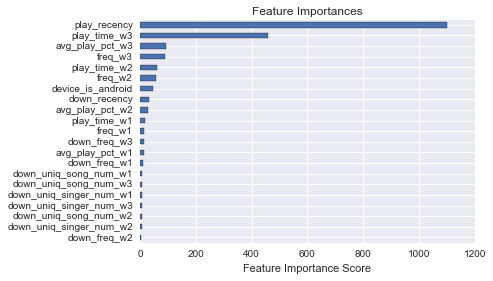

In [35]:
%%time
xgb_fit(xgb1, X_train, y_train, X_test, y_test)

Use the built-in CV in xgboost to determine the best n_estimators...

[0]	train-auc:0.893236+0.00425081	test-auc:0.893019+0.00473687
[1]	train-auc:0.901301+0.00443353	test-auc:0.901078+0.00505899
[2]	train-auc:0.904514+0.000713555	test-auc:0.904205+0.00132848
[3]	train-auc:0.90546+0.000533957	test-auc:0.905057+0.000615586
[4]	train-auc:0.905877+0.000464609	test-auc:0.905449+0.0010528
[5]	train-auc:0.906305+0.000332197	test-auc:0.905856+0.000783181
[6]	train-auc:0.906661+0.000251444	test-auc:0.90617+0.000770214
[7]	train-auc:0.906789+0.000367917	test-auc:0.906282+0.000641423
[8]	train-auc:0.907166+0.00022115	test-auc:0.906617+0.000753152
[9]	train-auc:0.90738+0.000196558	test-auc:0.906787+0.00074555
[10]	train-auc:0.907604+0.000246695	test-auc:0.906962+0.000713376
[11]	train-auc:0.907778+0.000289575	test-auc:0.907112+0.000694058
[12]	train-auc:0.908025+0.00020982	test-auc:0.907308+0.000755121
[13]	train-auc:0.908178+0.000187029	test-auc:0.907423+0.000773717
[14]	train-auc:0.908362+0.000

[124]	train-auc:0.914793+0.00021679	test-auc:0.910354+0.000947033
[125]	train-auc:0.914827+0.000226751	test-auc:0.910355+0.000943283
[126]	train-auc:0.914862+0.00021712	test-auc:0.91036+0.000943315
[127]	train-auc:0.914885+0.000213614	test-auc:0.910354+0.000940992
[128]	train-auc:0.914922+0.000211452	test-auc:0.910352+0.000953231
[129]	train-auc:0.914955+0.000215335	test-auc:0.910348+0.000950965
[130]	train-auc:0.914979+0.000221185	test-auc:0.910352+0.000943883
[131]	train-auc:0.915005+0.000220641	test-auc:0.910349+0.00094493
[132]	train-auc:0.915052+0.000235752	test-auc:0.910359+0.000942595
[133]	train-auc:0.915096+0.000235446	test-auc:0.910358+0.000940187
[134]	train-auc:0.915132+0.000229985	test-auc:0.910363+0.000947251
[135]	train-auc:0.915149+0.000239834	test-auc:0.910364+0.000946736
[136]	train-auc:0.915182+0.000236153	test-auc:0.910369+0.000948173
[137]	train-auc:0.915202+0.000236188	test-auc:0.910366+0.000945968
[138]	train-auc:0.915233+0.000239174	test-auc:0.910377+0.000939334

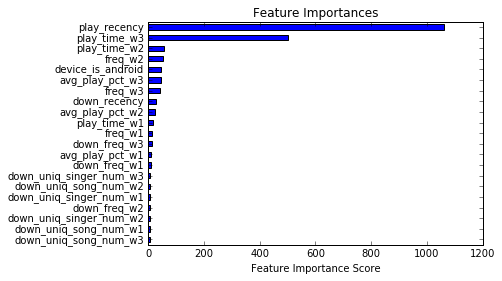

In [10]:
%%time
xgb1_1 = XGBClassifier(
    learning_rate=0.2,
    n_estimators=300,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    n_jobs=2,
    random_state=RANDOM_SEED)
xgb_fit(xgb1_1, X_train, y_train, X_test, y_test)

Use the built-in CV in xgboost to determine the best n_estimators...

[0]	train-auc:0.893236+0.00425081	test-auc:0.893019+0.00473687
[1]	train-auc:0.901537+0.0045284	test-auc:0.901235+0.00517903
[2]	train-auc:0.905059+0.000809956	test-auc:0.904715+0.00129331
[3]	train-auc:0.905924+0.000425076	test-auc:0.90554+0.00066946
[4]	train-auc:0.906394+0.000435341	test-auc:0.905987+0.00104956
[5]	train-auc:0.906874+0.00043783	test-auc:0.906415+0.000896076
[6]	train-auc:0.907306+0.000276037	test-auc:0.906757+0.000777941
[7]	train-auc:0.907543+0.000340589	test-auc:0.90694+0.000643204
[8]	train-auc:0.907957+0.000181671	test-auc:0.907317+0.000728012
[9]	train-auc:0.908192+0.000209077	test-auc:0.907489+0.000683794
[10]	train-auc:0.908459+0.000253945	test-auc:0.907671+0.00067563
[11]	train-auc:0.908703+0.00027852	test-auc:0.907868+0.000663151
[12]	train-auc:0.908926+0.00028078	test-auc:0.908057+0.000676939
[13]	train-auc:0.909182+0.000287703	test-auc:0.908242+0.000654531
[14]	train-auc:0.90939+0.00028

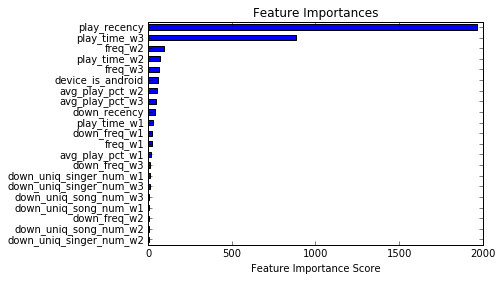

In [14]:
%%time
xgb1_2 = XGBClassifier(
    learning_rate=0.3,
    n_estimators=300,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    n_jobs=2,
    random_state=RANDOM_SEED)
xgb_fit(xgb1_2, X_train, y_train, X_test, y_test)

### Step 2: Tune max_depth and min_child_weight

In [29]:
param_step_2 = {
 'max_depth': range(3, 10, 2),
 'min_child_weight': range(1, 6, 2)
}
# param_step_2 = {
#  'max_depth': [9],
#  'min_child_weight': [1]
# }

In [30]:
gsearch2 = GridSearchCV(
    estimator=XGBClassifier(learning_rate=0.3, n_estimators=58, 
                            gamma=0, subsample=0.8, colsample_bytree=0.8,
                            objective='binary:logistic', n_jobs=2, random_state=RANDOM_SEED), 
    param_grid = param_step_2, scoring='roc_auc', iid=False, cv=3)

In [31]:
%%time
gsearch2.fit(X_train, y_train)

CPU times: user 16min 9s, sys: 11.3 s, total: 16min 20s
Wall time: 8min 50s


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=58,
       n_jobs=2, nthread=None, objective='binary:logistic',
       random_state=24, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [34]:
pd.DataFrame(gsearch2.cv_results_).sort_values('mean_test_score', ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_child_weight,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
8,14.929129,0.298625,0.910161,0.919503,7,5,"{u'max_depth': 7, u'min_child_weight': 5}",1,0.909136,0.920134,0.910410,0.919138,0.910939,0.919236,0.318571,0.005967,0.000757,0.000448
5,11.301912,0.241821,0.909951,0.913508,5,5,"{u'max_depth': 5, u'min_child_weight': 5}",2,0.909029,0.913937,0.910104,0.913406,0.910721,0.913182,1.161262,0.004707,0.000699,0.000317
7,15.258667,0.297316,0.909920,0.919918,7,3,"{u'max_depth': 7, u'min_child_weight': 3}",3,0.908779,0.920124,0.910324,0.919993,0.910657,0.919639,0.609435,0.003994,0.000818,0.000205
3,10.818931,0.243432,0.909880,0.913851,5,1,"{u'max_depth': 5, u'min_child_weight': 1}",4,0.908842,0.914196,0.910079,0.913831,0.910718,0.913526,0.303628,0.004487,0.000778,0.000274
6,14.968206,0.298754,0.909870,0.920764,7,1,"{u'max_depth': 7, u'min_child_weight': 1}",5,0.908830,0.920931,0.910237,0.920940,0.910542,0.920421,0.178077,0.001925,0.000746,0.000243
4,10.804564,0.244593,0.909838,0.913563,5,3,"{u'max_depth': 5, u'min_child_weight': 3}",6,0.908672,0.913926,0.910059,0.913497,0.910781,0.913266,0.393774,0.009092,0.000875,0.000273
11,19.245031,0.368992,0.909132,0.928062,9,5,"{u'max_depth': 9, u'min_child_weight': 5}",7,0.908375,0.928291,0.909319,0.928133,0.909703,0.927762,0.203884,0.006076,0.000558,0.000222
10,20.473168,0.369676,0.908859,0.929416,9,3,"{u'max_depth': 9, u'min_child_weight': 3}",8,0.907949,0.929492,0.909180,0.929634,0.909448,0.929123,1.470077,0.006706,0.000652,0.000215
9,19.770439,0.371366,0.908712,0.932550,9,1,"{u'max_depth': 9, u'min_child_weight': 1}",9,0.907679,0.932560,0.909310,0.931673,0.909148,0.933418,0.344583,0.007172,0.000734,0.000712
2,6.758218,0.180024,0.908186,0.909224,3,5,"{u'max_depth': 3, u'min_child_weight': 5}",10,0.907253,0.909617,0.908316,0.909106,0.908989,0.908947,0.389326,0.003716,0.000714,0.000286


In [37]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 7, 'min_child_weight': 5}, 0.91016130021499986)

In [40]:
param_step_2_1 = {
 'max_depth': [6, 7, 8],
 'min_child_weight': [4, 5, 6]
}

In [43]:
gsearch_2_1 = GridSearchCV(
    estimator=XGBClassifier(learning_rate=0.3, n_estimators=58, 
                            gamma=0, subsample=0.8, colsample_bytree=0.8,
                            objective= 'binary:logistic', n_jobs=2, random_state=RANDOM_SEED), 
    param_grid = param_step_2_1, scoring='roc_auc', iid=False, cv=3)

In [44]:
%%time
gsearch_2_1.fit(X_train, y_train)

CPU times: user 15min 3s, sys: 11.8 s, total: 15min 15s
Wall time: 8min 21s


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=58,
       n_jobs=2, nthread=None, objective='binary:logistic',
       random_state=24, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'max_depth': [6, 7, 8], 'min_child_weight': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [45]:
gsearch_2_1.best_params_, gsearch_2_1.best_score_
# the best values for max_depth and min_child_weight remain the same

({'max_depth': 7, 'min_child_weight': 5}, 0.91016130021499986)

### Step 3: Tune gamma

In [46]:
param_step_3 = {
 'gamma': [i/10.0 for i in range(0,5)]
}

In [47]:
gsearch3 = GridSearchCV(
    estimator=XGBClassifier(learning_rate=0.3, n_estimators=58, max_depth=7,
                            min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
                            objective= 'binary:logistic', n_jobs=2, random_state=RANDOM_SEED), 
    param_grid=param_step_3, scoring='roc_auc', iid=False, cv=3)

In [48]:
%%time
gsearch3.fit(X_train, y_train)

CPU times: user 8min 13s, sys: 5.34 s, total: 8min 18s
Wall time: 4min 29s


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=58,
       n_jobs=2, nthread=None, objective='binary:logistic',
       random_state=24, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [50]:
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, 0.91016130021499986)

Use the built-in CV in xgboost to determine the best n_estimators...

[0]	train-auc:0.897958+0.00438208	test-auc:0.896846+0.00488202
[1]	train-auc:0.905825+0.00413018	test-auc:0.904458+0.0047601
[2]	train-auc:0.909024+0.000734621	test-auc:0.907549+0.00146735
[3]	train-auc:0.909827+0.000464724	test-auc:0.908193+0.000797246
[4]	train-auc:0.910326+0.000377419	test-auc:0.908531+0.001066
[5]	train-auc:0.910847+0.000342203	test-auc:0.908863+0.000803333
[6]	train-auc:0.911368+0.00025087	test-auc:0.909223+0.000804747
[7]	train-auc:0.911639+0.000382978	test-auc:0.909314+0.000666389
[8]	train-auc:0.912037+0.000263131	test-auc:0.909559+0.000720631
[9]	train-auc:0.912292+0.000243308	test-auc:0.909653+0.000734179
[10]	train-auc:0.912569+0.000289884	test-auc:0.909764+0.000690288
[11]	train-auc:0.91282+0.000299398	test-auc:0.909874+0.000665685
[12]	train-auc:0.913049+0.000304372	test-auc:0.909948+0.000649984
[13]	train-auc:0.913255+0.000317734	test-auc:0.910014+0.000651341
[14]	train-auc:0.913483+0.0

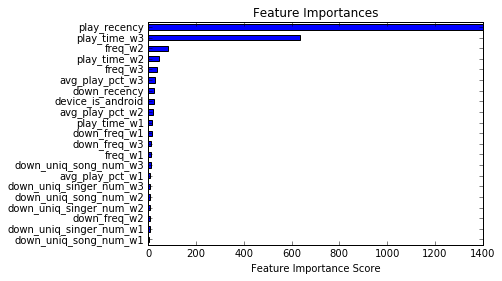

In [51]:
# re-calibrate the number of boosting rounds for the updated parameters.
xgb3 = XGBClassifier(
 learning_rate=0.3,
 n_estimators=300,
 max_depth=7,
 min_child_weight=5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 n_jobs=2,
 random_state=RANDOM_SEED)
xgb_fit(xgb3, X_train, y_train, X_test, y_test)

### Step 4: Tune subsample and colsample_bytree

In [52]:
param_step_4 = {
 'subsample': [i/10.0 for i in range(6,10)],
 'colsample_bytree': [i/10.0 for i in range(6,10)]
}

In [53]:
gsearch4 = GridSearchCV(
    estimator=XGBClassifier(learning_rate=0.3, n_estimators=31, max_depth=7,
                            min_child_weight=5, gamma=0,
                            objective= 'binary:logistic', n_jobs=2, random_state=RANDOM_SEED), 
    param_grid=param_step_4, scoring='roc_auc',iid=False, cv=5)

CPU times: user 58 µs, sys: 75 µs, total: 133 µs
Wall time: 131 µs


In [54]:
%%time
gsearch4.fit(X_train, y_train)

CPU times: user 29min 6s, sys: 30.1 s, total: 29min 36s
Wall time: 16min 22s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=31,
       n_jobs=2, nthread=None, objective='binary:logistic',
       random_state=24, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [55]:
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.9}, 0.91072818087424001)

In [56]:
param_step_4_1 = {
 'subsample': [0.85, 0.9, 0.95],
 'colsample_bytree': [0.75, 0.8, 0.85]
}
gsearch4_1 = GridSearchCV(
    estimator=XGBClassifier(learning_rate=0.3, n_estimators=31, max_depth=7,
                            min_child_weight=5, gamma=0,
                            objective= 'binary:logistic', n_jobs=2, random_state=RANDOM_SEED), 
    param_grid=param_step_4_1, scoring='roc_auc',iid=False, cv=5)

In [57]:
%%time
gsearch4_1.fit(X_train, y_train)

CPU times: user 17min 9s, sys: 17.5 s, total: 17min 26s
Wall time: 9min 40s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=31,
       n_jobs=2, nthread=None, objective='binary:logistic',
       random_state=24, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'subsample': [0.85, 0.9, 0.95], 'colsample_bytree': [0.75, 0.8, 0.85]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [58]:
gsearch4_1.best_params_, gsearch4_1.best_score_
# remain the same...

({'colsample_bytree': 0.8, 'subsample': 0.9}, 0.91072818087424001)

### Step 5: Tuning Regularization Parameters

In [64]:
param_step_5 = {
 'reg_lambda':[1e-3, 1e-2, 0.1, 1, 10, 100]
}
gsearch5 = GridSearchCV(
    estimator = XGBClassifier(learning_rate=0.3, n_estimators=31, max_depth=7,
                              min_child_weight=5, gamma=0, subsample=0.9, colsample_bytree=0.8,
                              objective= 'binary:logistic', n_jobs=2, random_state=RANDOM_SEED),  
    param_grid = param_step_5, scoring='roc_auc', iid=False, cv=5)

In [65]:
%%time
gsearch5.fit(X_train, y_train)

CPU times: user 11min 15s, sys: 11.4 s, total: 11min 27s
Wall time: 6min 17s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=31,
       n_jobs=2, nthread=None, objective='binary:logistic',
       random_state=24, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'reg_lambda': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [67]:
pd.DataFrame(gsearch5.cv_results_).sort_values('mean_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_reg_lambda,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,11.697673,0.135016,0.910513,0.916271,0.1,{u'reg_lambda': 0.1},6,0.909985,0.916540,0.909809,...,0.909962,0.916499,0.912843,0.915679,0.909964,0.916240,0.630302,0.001450,0.001167,0.000314
0,11.297015,0.137302,0.910524,0.916116,0.001,{u'reg_lambda': 0.001},5,0.909929,0.915992,0.909971,...,0.909931,0.916200,0.912753,0.915670,0.910037,0.916190,0.581284,0.004485,0.001115,0.000281
1,11.192227,0.138585,0.910593,0.916277,0.01,{u'reg_lambda': 0.01},4,0.909946,0.916378,0.910007,...,0.910113,0.916651,0.912861,0.915738,0.910038,0.916189,0.344327,0.004192,0.001135,0.000307
5,11.471882,0.130426,0.910706,0.913974,100,{u'reg_lambda': 100},3,0.910219,0.914080,0.910169,...,0.910245,0.914013,0.912778,0.913517,0.910121,0.914357,0.166658,0.002732,0.001037,0.000273
3,11.068352,0.143268,0.910728,0.916077,1,{u'reg_lambda': 1},2,0.910204,0.916022,0.910010,...,0.910472,0.916427,0.912794,0.915492,0.910160,0.916394,0.091761,0.005097,0.001044,0.000337
4,11.411044,0.143007,0.910773,0.915592,10,{u'reg_lambda': 10},1,0.910315,0.915544,0.910224,...,0.910350,0.915731,0.912945,0.914809,0.910029,0.915932,0.387753,0.003834,0.001092,0.000418


In [68]:
gsearch5.best_params_, gsearch5.best_score_

({'reg_lambda': 10}, 0.91077256632459291)

Use the built-in CV in xgboost to determine the best n_estimators...

[0]	train-auc:0.89684+0.00393851	test-auc:0.895997+0.00441139
[1]	train-auc:0.904938+0.00408942	test-auc:0.903801+0.00473709
[2]	train-auc:0.908294+0.000845497	test-auc:0.906994+0.00149119
[3]	train-auc:0.909158+0.000485727	test-auc:0.90776+0.000815362
[4]	train-auc:0.909829+0.000366774	test-auc:0.908213+0.00104116
[5]	train-auc:0.910387+0.000337328	test-auc:0.908655+0.000843208
[6]	train-auc:0.910957+0.000253223	test-auc:0.909069+0.000833526
[7]	train-auc:0.911253+0.000355922	test-auc:0.909245+0.000702098
[8]	train-auc:0.911679+0.000255694	test-auc:0.9095+0.000765759
[9]	train-auc:0.911981+0.00021893	test-auc:0.909656+0.000782846
[10]	train-auc:0.912249+0.000248694	test-auc:0.909786+0.000760562
[11]	train-auc:0.912499+0.000291967	test-auc:0.909886+0.000723613
[12]	train-auc:0.912771+0.000258169	test-auc:0.910013+0.00076989
[13]	train-auc:0.913009+0.000239762	test-auc:0.910105+0.000781685
[14]	train-auc:0.913217+0.00

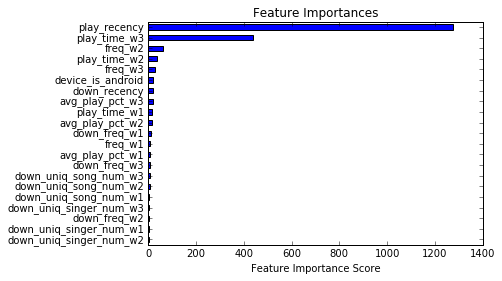

In [69]:
%%time
xgb5 = XGBClassifier(
 learning_rate=0.3,
 n_estimators=300,
 max_depth=7,
 min_child_weight=5,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 reg_lambda=10,
 n_jobs=2,
 random_state=RANDOM_SEED)
xgb_fit(xgb5, X_train, y_train, X_test, y_test)

### Step 6: Reducing Learning Rate

Use the built-in CV in xgboost to determine the best n_estimators...

[0]	train-auc:0.89684+0.00393851	test-auc:0.895997+0.00441139
[1]	train-auc:0.904383+0.00406597	test-auc:0.903256+0.0046028
[2]	train-auc:0.907354+0.00104946	test-auc:0.906107+0.00161911
[3]	train-auc:0.908099+0.000523544	test-auc:0.906857+0.000746093
[4]	train-auc:0.908391+0.00061518	test-auc:0.907083+0.00117526
[5]	train-auc:0.908767+0.000416395	test-auc:0.907452+0.000840897
[6]	train-auc:0.909161+0.000315065	test-auc:0.907781+0.000767381
[7]	train-auc:0.909266+0.000497602	test-auc:0.907848+0.000527145
[8]	train-auc:0.909555+0.000344133	test-auc:0.908115+0.000672742
[9]	train-auc:0.909784+0.000214503	test-auc:0.908296+0.000768552
[10]	train-auc:0.90997+0.000267363	test-auc:0.908454+0.000713293
[11]	train-auc:0.910097+0.000362869	test-auc:0.908532+0.000659502
[12]	train-auc:0.910313+0.000292956	test-auc:0.908697+0.000705544
[13]	train-auc:0.910473+0.000230222	test-auc:0.908823+0.000750649
[14]	train-auc:0.910644+0.0

[124]	train-auc:0.916871+0.00018459	test-auc:0.911389+0.000814105
[125]	train-auc:0.916899+0.000181215	test-auc:0.911391+0.000814711
[126]	train-auc:0.916943+0.000180605	test-auc:0.911394+0.000813482
[127]	train-auc:0.916977+0.000174939	test-auc:0.911403+0.000810713
[128]	train-auc:0.917006+0.000196328	test-auc:0.911404+0.000808337
[129]	train-auc:0.91704+0.000201219	test-auc:0.911405+0.00080597
[130]	train-auc:0.917072+0.000206885	test-auc:0.911405+0.000802663
[131]	train-auc:0.917114+0.000198002	test-auc:0.911407+0.000803983
[132]	train-auc:0.917152+0.000198584	test-auc:0.911412+0.000803417
[133]	train-auc:0.917199+0.000191975	test-auc:0.911421+0.000801687
[134]	train-auc:0.917217+0.00019106	test-auc:0.911421+0.000803383
[135]	train-auc:0.917244+0.000203433	test-auc:0.911426+0.000799342
[136]	train-auc:0.917279+0.000208496	test-auc:0.911427+0.000795097
[137]	train-auc:0.917314+0.000203417	test-auc:0.91143+0.000799486
[138]	train-auc:0.91735+0.00021273	test-auc:0.911432+0.000800196
[1

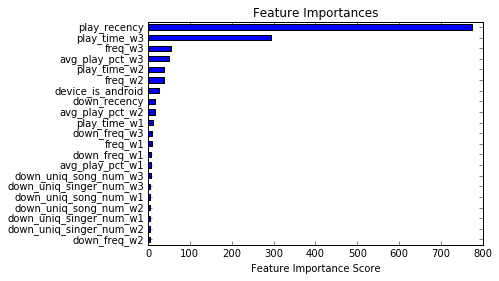

In [70]:
%%time
xgb6 = XGBClassifier(
 learning_rate=0.1,
 n_estimators=500,
 max_depth=7,
 min_child_weight=5,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 reg_lambda=10,
 n_jobs=2,
 random_state=RANDOM_SEED)
xgb_fit(xgb6, X_train, y_train, X_test, y_test)

In [79]:
feat_imp_df = pd.Series(xgb6.get_booster().get_score(importance_type='gain')).sort_values(ascending=False).reset_index()

In [81]:
feat_imp_df.columns = ['feature', 'feature_importance_score']

In [83]:
import seaborn as sns

In [87]:
feat_imp_df

,feature,feature_importance_score
0,play_recency,773.789459
1,play_time_w3,294.753367
2,freq_w3,55.356464
3,avg_play_pct_w3,48.824031
4,play_time_w2,37.283628
5,freq_w2,37.221991
6,device_is_android,26.084728
7,down_recency,16.917462
8,avg_play_pct_w2,16.808225
9,play_time_w1,11.705024


In [89]:
sns.set_style("whitegrid")

/Users/Meng/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


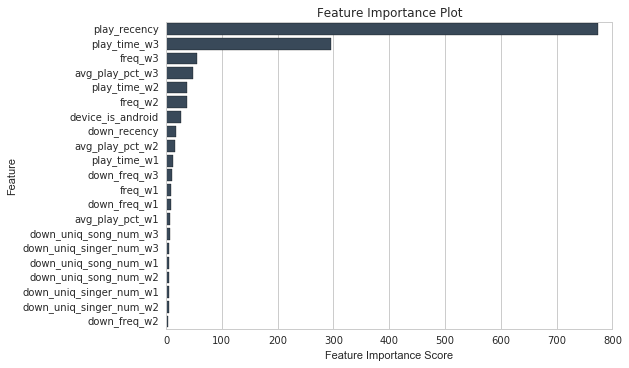

In [90]:
fig, ax = plt.subplots()
#fig.set_size_inches((5, 10))
sns.barplot(x='feature_importance_score', y='feature', data=feat_imp_df, color="#34495e", ax=ax)
ax.set(xlabel='Feature Importance Score', ylabel='Feature')
ax.set_title('Feature Importance Plot')
plt.show()

In [96]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572171 entries, 0 to 572170
Data columns (total 22 columns):
freq_w1                    572171 non-null float64
play_time_w1               572171 non-null float64
avg_play_pct_w1            572171 non-null float64
freq_w2                    572171 non-null float64
play_time_w2               572171 non-null float64
avg_play_pct_w2            572171 non-null float64
freq_w3                    572171 non-null float64
play_time_w3               572171 non-null float64
avg_play_pct_w3            572171 non-null float64
play_recency               572171 non-null int64
down_freq_w1               572171 non-null float64
down_uniq_song_num_w1      572171 non-null float64
down_uniq_singer_num_w1    572171 non-null float64
down_freq_w2               572171 non-null float64
down_uniq_song_num_w2      572171 non-null float64
down_uniq_singer_num_w2    572171 non-null float64
down_freq_w3               572171 non-null float64
down_uniq_song_num_w3   